## Added Jupyter Notebook from ExampleRepo

- **Source**: This Jupyter notebook was originally taken from the [Driving_Cycle](https://github.com/xxx).
- **Author(s)**: xx xx
- **Date**: August 30, 2024

### Modifications:
- Updated the data paths to match the structure of this repository.
- Added additional comments for clarity.
- Minor tweaks to the visualization code.
- Deleted some unnecessary sections in the context of this work.

### License Considerations:
- This notebook was originally shared under the MIT License. The same license applies to this version.

In [38]:
# Import necessary libraries
import os # module to interact with the operating system.
import numpy as np # for numerical computations, aliased as np.
import scipy.io # module to work with MATLAB files.
import matplotlib.pyplot as plt # for creating plots.
from dtaidistance import dtw # for dynamic time warping distance calculation.
from dtaidistance import dtw_visualisation as dtwvis #  for visualizing dynamic time warping results.
from random import choices # for random sampling.

In [39]:
# Set the data folder path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
data_folder = os.path.join(parent_dir,r'data\raw')
print(data_folder)

g:\My Drive\projects\research\IgdirDrivingCyclesML\data\raw


In [40]:
# Get the file information for all .txt files in the data folder and sort them
file_names = [f for f in os.listdir(data_folder) if f.endswith('.txt')]
file_names=sorted(file_names)
print(file_names)

['D01.txt', 'D02.txt', 'D03.txt', 'D04.txt', 'D05.txt', 'D06.txt', 'D07.txt', 'D08.txt', 'D09.txt', 'D10.txt', 'D11.txt', 'D12.txt', 'D13.txt', 'D14.txt', 'D15.txt', 'D16.txt', 'D17.txt', 'D18.txt', 'D19.txt']


In [41]:
# Initialize variables
num_cycles = len(file_names)
num_segments = 6
speed_data = [None] * num_cycles
data_files = []

In [42]:
# Function for finding the first and last non zero elements in an array
def non_zero_index(arr):
    start_of_cycle = -1
    end_of_cycle = -1
    for i, val in enumerate(arr):
        if val != 0:
            if start_of_cycle == -1:
                start_of_cycle = i
            end_of_cycle = i
    return start_of_cycle, end_of_cycle

In [43]:
# Perform data preprocessing for each file (driving cycle)
for i in range(num_cycles):
    # Load the data from the current file (driving cycle)
    data = np.loadtxt(os.path.join(data_folder, file_names[i]))
    data = data[:, 1]  # Exclude indexing (first) column and measured acceleration (third) column
    # Find the start and end indices of the nonzero values
    start_group_index, end_group_index = non_zero_index(data)
    # Remove unnecessary waiting times at the beginning and end of cycles
    if start_group_index > 0:
        start_group_index -= 1
    if end_group_index < len(data):
        end_group_index += 1
    # Remove zeros from start and end
    data = data[start_group_index:end_group_index+1]
    # Save the preprocessed data into speed_data
    speed_data[i] = data

for i in range(num_cycles):
    datax = np.zeros((len(speed_data[i]), 2))
    datax[:,0] = speed_data[i].copy()
    for j in range(len(datax) - 1):
        datax[j, 1] = (datax[j + 1, 0] - datax[j, 0]) / 3.6
    data_files.append(datax)

In [44]:
# Initialize variables for minimum and maximum accelerations
min_accs = np.zeros(num_cycles)
max_accs = np.zeros(num_cycles)

# Find the minimum and maximum accelerations for each cycle
for i in range(num_cycles):
    min_accs[i] = np.min(data_files[i][:, 1])
    max_accs[i] = np.max(data_files[i][:, 1])

# Find the overall minimum acceleration and maximum acceleration
min_acc = np.min(min_accs)
max_acc = np.max(max_accs)

# Calculate maximum speed decrease and maximum speed increase
max_speed_decrease = min_acc * 3.6
max_speed_increase = max_acc * 3.6

In [45]:
# Load sizes of the segments
mat_data = scipy.io.loadmat(os.path.join(data_folder, 'segment_sizes.mat'))
segment_sizes = mat_data['segment_sizes'][:,0]

# Initialize variable for segments
segments = [None] * len(segment_sizes)

In [46]:
# Get segments from cycles according to the segment sizes
for i in range(num_cycles):
    driving_cycle = data_files[i]
    start_index = 0
    for j in range(num_segments * i, num_segments * (i + 1)):
        end_index = start_index + segment_sizes[j] - 1
        segments[j] = driving_cycle[start_index:end_index + 1, :]
        start_index = end_index + 1

# Initialize variable for all segments
all_segments = [[None for _ in range(num_cycles)] for _ in range(num_segments)]

# Get all segments
k = -1
for i in range(num_cycles):
    for j in range(num_segments):
        k += 1
        all_segments[j][i] = np.array(segments[k])

In [47]:
# Initialize variables for average first and last speeds
avg_first_speeds = np.zeros(num_segments)
avg_last_speeds = np.zeros(num_segments)

# Calculate the average of the first and last speeds for each segment
for i in range(num_segments):
    avg_first_speeds[i] = np.mean([segment[0, 0] for segment in all_segments[i]])
    avg_last_speeds[i] = np.mean([segment[-1, 0] for segment in all_segments[i]])

# Create groups of combined segments
combined_segments_groups = [np.concatenate(all_segments[i]) for i in range(num_segments)]

In [48]:
# Compute the distance matrix and find the reference driving segment for each
# segment group using Dynamic Time Warping (DTW)

# Initialize variables
dist_matrix = np.zeros((num_cycles, num_cycles))
total_dist = np.zeros(num_segments)
ref_seg = np.zeros(num_segments, dtype=int)
seg_start_speed = np.zeros(num_segments + 1)
seg_end_speed = np.zeros(num_segments + 1)

# Compute the distance matrix and find the reference driving segment for each
# segment group using Dynamic Time Warping (DTW)
for seg in range(num_segments):
    k = 0
    for i in range(num_cycles):
        for j in range(num_cycles):
            k += 1
            x = all_segments[seg][i][:, 0]
            y = all_segments[seg][j][:, 0]
            dist_matrix[i, j] =  dtw.distance_fast(x, y)

    total_dist[seg] = np.sum(dist_matrix, axis=0).min()
    ref_seg[seg] = np.argmin(np.sum(dist_matrix, axis=0))
    seg_start_speed[seg + 1] = all_segments[seg][ref_seg[seg]][0, 0]
    seg_end_speed[seg + 1] = all_segments[seg][ref_seg[seg]][-1, 0]

    # To maintain reasonable acceleration limits, segments from the same cycle
    # are selected if the acceleration at the transition exceeds the maximum
    # acceleration or deceleration.
    if abs(seg_start_speed[seg + 1] - seg_end_speed[seg]) > max_speed_increase:
        ref_seg[seg] = ref_seg[seg - 1]

In [49]:
# Get the reference segment's lengths
ref_seg_lengths = np.zeros(num_segments, dtype=int)
for seg in range(num_segments):
    ref_seg_lengths[seg] = len(all_segments[seg][ref_seg[seg]])

# Set number of Monte Carlo trials
MCT = 10000

# Set speed and acceleration intervals
v_res = 2.5  # Speed interval 2.5 km/h
a_res = 0.25  # Acceleration interval 0.25 m/s^2

# set sizes of figures
fig_height=2*3.54
fig_width=3*3.54

# Initialize variable for Monte Carlo trials
mct_cons_dc_speed = [[[] for _ in range(MCT)] for _ in range(num_segments)]
last_speed = np.zeros((num_segments, MCT))

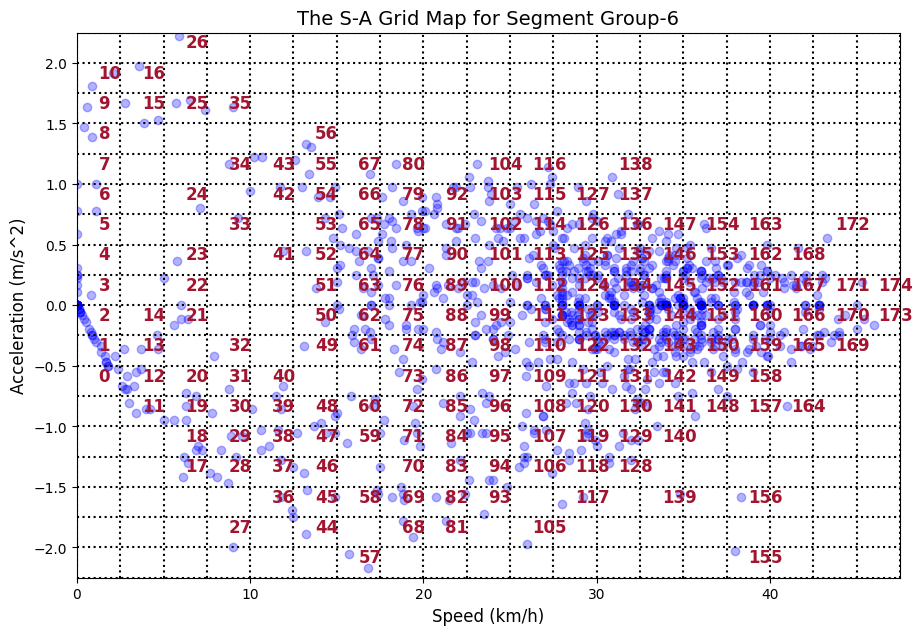

In [50]:
for seg in range(num_segments):
  data_states = combined_segments_groups[seg]
  # For the current segment group calculate following kinematics
  speed_data = data_states[:, 0]  # Speed data
  avg_speed = np.mean(speed_data)  # Average speed
  max_speed = np.max(speed_data)  # Maximum speed
  min_speed = np.min(speed_data)  # Minimum speed
  acc_data = data_states[:, 1]  # Acceleration data
  avg_acc = np.mean(acc_data)  # Average acceleration
  max_acc = np.max(acc_data)  # Maximum acceleration
  min_acc = np.min(acc_data)  # Minimum acceleration
  acc_lower_bound = np.floor(min_acc / a_res) * a_res # Acc lower bound
  acc_upper_bound = np.ceil(max_acc / a_res) * a_res + a_res # Acc upper bound
  speed_lower_bound = np.floor(min_speed / v_res) * v_res  # Speed lower bound
  speed_upper_bound = np.ceil(max_speed / v_res) * v_res + v_res # Speed upper bound
  a_steps = np.arange(acc_lower_bound, acc_upper_bound + a_res, a_res) # Acceleration steps
  v_steps = np.arange(speed_lower_bound, speed_upper_bound + v_res, v_res) # Speed steps

  # Create States for Markov-Chain Model
  # State assignment of Speed-Acceleration pairs in segment groups
  data_length = len(speed_data)  # Length of segment group
  group_index = np.arange(0, data_length)
  group_states = np.zeros((data_length, 3))
  k = -1

  for i in range(len(v_steps) - 1):
    L_v = v_steps[i] # Lower speed of state
    U_v = v_steps[i + 1] # Upper speed of state

    for j in range(len(a_steps) - 1):
      L_a = a_steps[j] # Lower Acc. of state
      U_a = a_steps[j + 1] # Upper Acc. of state
      k = k + 1

      ind_v = group_index[(data_states[:, 0] >= L_v) & (data_states[:, 0] < U_v)] # Indices of speeds
      ind_a = group_index[(data_states[:, 1] >= L_a) & (data_states[:, 1] < U_a)] # Indices of acc

      matches = np.intersect1d(ind_a, ind_v)

      if len(matches) == 0:
        k = k- 1


      group_states[matches, 0] = k
      group_states[matches, 1] = (L_v + U_v) / 2
      group_states[matches, 2] = (L_a + U_a) / 2

  uniq_group_states, tags = np.unique(group_states, axis=0, return_inverse=True)

  if seg==num_segments-1: # plotting only for the sixth segment group
    # To plot S-A grid map with assigned states uncomment followings,
    fig = plt.figure(figsize=(10.62, 7.08))
    ax = fig.add_subplot(111)
    ax.scatter(data_states[:, 0], data_states[:, 1], marker='o', facecolor='b', edgecolor='b',
                  label='S-A Grid Values and States', alpha=0.3)
    ax.hlines(a_steps, xmin=speed_lower_bound, xmax=speed_upper_bound - v_res, colors='k', linestyles='dotted')
    ax.vlines(v_steps, ymin=acc_lower_bound, ymax=acc_upper_bound - a_res, colors='k', linestyles='dotted')
    for i in range(len(uniq_group_states)):
        ax.text(uniq_group_states[i, 1], uniq_group_states[i, 2], int(uniq_group_states[i,0]),
                  fontweight='bold', fontsize=12, color=[0.635, 0.0784, 0.1843])
    ax.set_xlim(speed_lower_bound, speed_upper_bound - v_res)
    ax.set_ylim(acc_lower_bound, acc_upper_bound - a_res)
    ax.set_title(f'The S-A Grid Map for Segment Group-{seg+1}', fontsize=14)
    ax.set_xlabel('Speed (km/h)', fontsize=12)
    ax.set_ylabel('Acceleration (m/s^2)', fontsize=12)
    # plt.savefig('/content/my_figures/SA_seg_'+str(seg+1)+'.eps', format='eps', bbox_inches='tight') # Save figure as eps file

  data_states_limits=np.hstack((data_states,group_states))
  number_states = len(uniq_group_states)

  # Calculate transition probability matrix
  tagged_dataset = data_states_limits[:, 0:3]
  current_state = tagged_dataset[:-1, 2]  # Current states
  next_state = tagged_dataset[1:, 2]  # Next states
  state_transitions = np.column_stack((current_state, next_state))

  # State Transition matrix that gives the # of transitions between states
  states = data_states_limits[:, 2]
  number_states = int(np.max(states))+1  # Number of unique states
  state_trans_matrix = np.zeros((number_states, number_states))
  for i in range(len(states) - 1):
      state_trans_matrix[int(states[i] ), int(states[i + 1])] += 1

  # State Transition Probability matrix that gives the probability of transitions between states
  trans_prob_matrix = state_trans_matrix / np.sum(state_trans_matrix, axis=1, keepdims=True)

  cycle_duration = ref_seg_lengths[seg] # Segment duration (same as reference segment)
  gen_states = np.zeros(cycle_duration, dtype=int) # Initialize variable for Generated states
  first_states = np.zeros((num_segments, MCT), dtype=int) # Initialize variable for First states

  # Generate new segments using Monte Carlo experiments to maintain the
  # stochastic nature of a Markov chain
  for mcti in range(MCT): #  Monte Carlo loop

    # Determine initial state for each segment
    if seg == 0: # First segment starts with zero speed and acceleration
        index = np.argmin(np.abs(data_states_limits[:, 0] - 0) + np.abs(data_states_limits[:, 1] - 0))
        first_states[seg, mcti] = data_states_limits[index, 2]
    else:
        # Subsequent segments start with initial states closest to the final
        # speed and acceleration of the previous segment
        index = np.argmin(np.abs(data_states_limits[:, 0] - last_speed[seg - 1, mcti]))
        first_states[seg, mcti] = data_states_limits[index, 2]

    # Generate driving segment
    gen_states = np.zeros(cycle_duration, dtype=int)
    gen_states[0] = first_states[seg, mcti]
    for i in range(1, cycle_duration): # State transitions
        cumsum_probs = np.cumsum(trans_prob_matrix[gen_states[i-1], :])
        gen_states[i] = np.argmax(np.random.rand() <= cumsum_probs)

    uniq_gen_states = np.unique(gen_states)
    state_values =  np.array([None]*len(uniq_gen_states))
    state_values[0] = np.where(data_states_limits[:, 2] == gen_states[0])[0]
    constructed_driving_segment = np.zeros((cycle_duration, 2)) # Constructed driving segment

    for i in range(1, len(uniq_gen_states)):
        state_values[i]=np.where(data_states_limits[:, 2] == uniq_gen_states[i])[0]

    for i in range(cycle_duration):
        # Get index of real data according to generated states
        index_in_data_states = state_values[np.where(uniq_gen_states == gen_states[i])[0][0]]
        if len(index_in_data_states) == 1:
            rand_State = index_in_data_states[0]
        else:
            rand_State = np.random.choice(index_in_data_states, size=1)[0]

        constructed_driving_segment[i] = data_states_limits[rand_State, :2]

    # If it's first segment,  the initial speed and acceleration start with 0
    if seg == 0:
        constructed_driving_segment[0] = [0, 0]

    mct_cons_dc_speed[seg][mcti]=constructed_driving_segment

    # Inter-segment memory unit
    last_speed[seg, mcti] = constructed_driving_segment[-1, 0]


In [51]:
# Compute DTW distance between reference and generated segments

dist_to_mcti = np.zeros((MCT, num_segments))

for seg in range(num_segments):
    y = all_segments[seg][ref_seg[seg]][:, 0]  # Reference segments
    for mcti in range(MCT):
        x = mct_cons_dc_speed[seg][mcti][:, 0]  # Generated segments
        dist_to_mcti[mcti][seg] = dtw.distance_fast(x, y)

In [52]:
# To select the best segment from the segments generated by Monte Carlo
# simulations, get the ones with the smallest DTW distance

M, I = np.min(dist_to_mcti, axis=0), np.argmin(dist_to_mcti, axis=0)
best_seg_from_MCT = []
for seg in range(num_segments):
    best_seg_from_MCT.append(mct_cons_dc_speed[seg] [I[seg]])

# Calculate acceleration of the constructed Driving Cycle
const_cycle = np.concatenate(best_seg_from_MCT)
for i in range(len(const_cycle) - 1):
    const_cycle[i, 1] = (const_cycle[i + 1, 0] - const_cycle[i, 0]) / 3.6

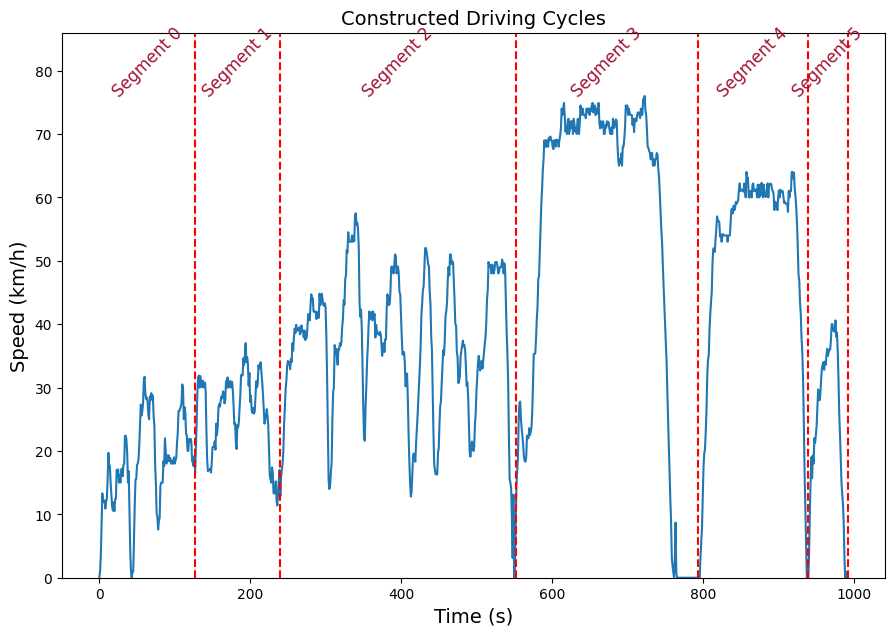

In [53]:
# Plot Constructed DC
fig=plt.figure(figsize=(fig_width,fig_height))
ax = fig.add_subplot(1, 1, 1)
plt.plot(const_cycle[:, 0])
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Speed (km/h)', fontsize=14)
plt.title('Constructed Driving Cycles', fontsize=14)
plt.ylim([0, np.max(const_cycle[:, 0]) + 10])
segmentLimits = np.cumsum(ref_seg_lengths)

for i in range(len(segmentLimits)):
    plt.axvline(segmentLimits[i], color='r', linestyle='--', linewidth=1.5)
    plt.text(segmentLimits[i] - ref_seg_lengths[i] / 2, np.max(const_cycle[:, 0]),
             f'Segment {i}', ha='center', fontsize=12, color=[0.635, 0.0784, 0.1843], rotation=45)

In [54]:
# Concatenate reference segments
comref_seg = [all_segments[seg][ref_seg[seg]] for seg in range(num_segments)]
comref_segments = np.concatenate(comref_seg)

# Calculate the DTW distance between the constructed and concatenated reference segments
dist_cons_ref = dtw.distance(const_cycle[:, 0], comref_segments[:, 0])
dist_cons_ref

57.515302311645826

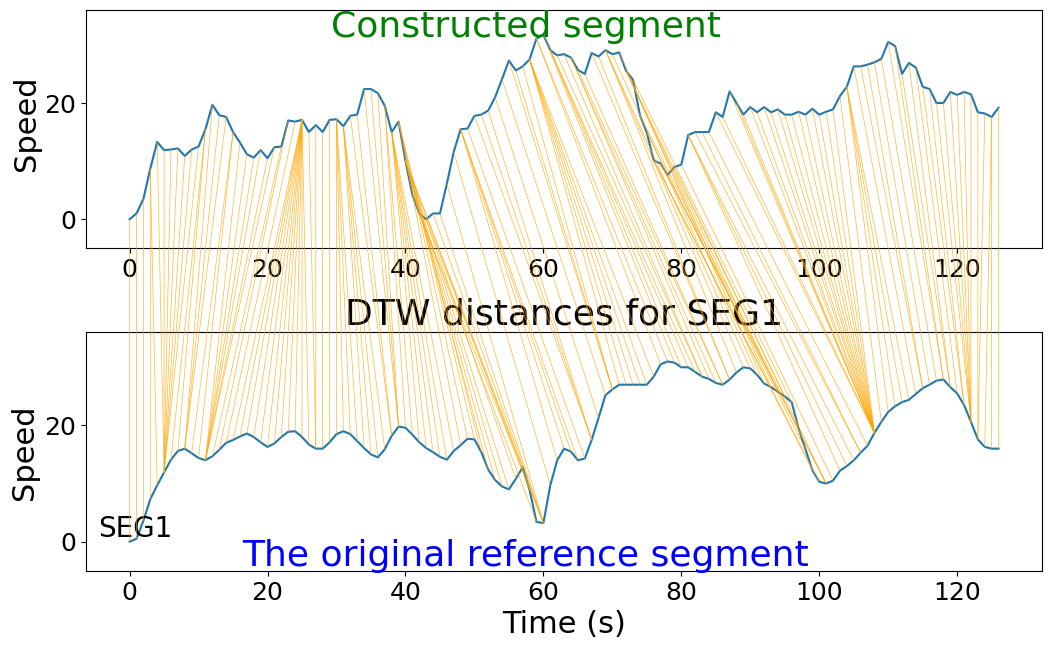

In [56]:
# Plot an example of dtw paths
# for seg in range(num_segments): #Draw for all segment groups
font_size=22
seg=0 #Draw only for a specific segment group
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(fig_width,fig_height))
x = mct_cons_dc_speed[seg][I[seg]][:, 0] # Constructed segment
y = all_segments[seg][ref_seg[seg]][:, 0] #The original reference segment
path = dtw.warping_path(x, y)
dtwvis.plot_warping(x, y, path,fig=fig, axs=axs)
plt.xlabel('Time (s)', fontsize=font_size)
plt.ylabel('Speed', fontsize=font_size)
plt.suptitle('Constructed segment',x=0.5, y=0.91, color='green', fontsize=font_size+4)
plt.figtext(0.5, 0.125, 'The original reference segment', ha='center', fontsize=font_size+4 , color='blue')
plt.figtext(0.03, 0.75, 'Speed', rotation=90, fontsize=font_size, ha='center', va='center')
for ax in axs: # change all tick sizes
    ax.tick_params(axis='x', labelsize=font_size-4)
    ax.tick_params(axis='y', labelsize=font_size-4)
    ax.set_ylim([np.min(y)-5, np.max(y)+5])
plt.title('DTW distances for SEG'+str(seg+1), color='black', fontsize=font_size+4, zorder=100)
plt.text(0.85, 0.8, 'SEG'+str(seg+1), ha='center', fontsize=font_size-2, color="black",zorder=10)
plt.tight_layout()
#plt.savefig('/content/my_figures/DTW_example.eps', format='eps',bbox_inches='tight') # Save figure as eps file

In [59]:
# Calculate RMSE
rmse = np.sqrt(np.mean((x - y) ** 2))

# Calculate MAE
mae = np.mean(np.abs(x - y))

# Print the results
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 9.562113560716138
MAE: 7.332283464566929
